In [1]:
# importing libraries
import os
import time
import numpy as np
import pyart
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import Dataset


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\scipy\sparse\linalg\isolve\iterative.py:10: DeprecationWarning: Please use `LinearOperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  from scipy.sparse.linalg.interface import LinearOperator
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\scipy\sparse\linalg\isolve\utils.py:7: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\scipy\sparse\linalg\isolve\utils.py:9: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is dep

In [2]:
# Path to radar data on my local machine.
radar_path = r'Z:/Matt/work/X_Band/'
rdr_files = os.listdir(radar_path)

In [3]:
# Verifying what files exist in the list of radar files. 
# In this case, I have several tar files that aren't opened.
rdr_files

['Radar_data',
 'gucxprecipradarS2.00.20220314.000031.raw.nc.tar',
 'gucxprecipradarS2.00.20220314.004440.raw.nc.tar',
 'gucxprecipradarS2.00.20220314.012831.raw.nc.tar',
 'gucxprecipradarS2.00.20220314.021215.raw.nc.tar',
 'gucxprecipradarS2.00.20220314.024143.raw.csu.sail-20220314-024143_47667_22_328_RHI.nc',
 'gucxprecipradarS2.00.20220314.024149.raw.csu.sail-20220314-024149_47668_22_330_RHI.nc',
 'gucxprecipradarS2.00.20220314.024155.raw.csu.sail-20220314-024155_47670_22_332_RHI.nc',
 'gucxprecipradarS2.00.20220314.024759.raw.csu.sail-20220314-024759_47699_22_1_PPI.nc',
 'gucxprecipradarS2.00.20220314.024831.raw.csu.sail-20220314-024831_47700_22_2_PPI.nc',
 'gucxprecipradarS2.00.20220314.024903.raw.csu.sail-20220314-024903_47701_22_4_PPI.nc',
 'gucxprecipradarS2.00.20220314.024935.raw.csu.sail-20220314-024935_47702_22_6_PPI.nc',
 'gucxprecipradarS2.00.20220314.025007.raw.csu.sail-20220314-025007_47703_22_8_PPI.nc',
 'gucxprecipradarS2.00.20220314.025039.raw.csu.sail-20220314-025039

Now for actually reading the data file we're looking for. In this case, we want the lowest elevation scan available. The CSU SAIL X-band radar data comes in individual netcdf files with the ending prefix of PPI or RHI. In this case, we want the lowest elevation scan of the PPI. We'll loop through the files in the directory and pull out the file with the name we're looking for. 

In [4]:
for i in sorted(range(len(rdr_files))):
    files = str(rdr_files[i])
    if '_1_PPI.nc' in str(files):
        filename = files
        
        # Joins the data to the path for it to be read
        filename = os.path.join(radar_path, filename)

        # Reads the data in.
        radar = pyart.io.read(filename)

In [5]:
        # Checking to make sure it's pulling the correct file name.
        filename

'Z:/Matt/work/X_Band/gucxprecipradarS2.00.20220314.024759.raw.csu.sail-20220314-024759_47699_22_1_PPI.nc'

In [6]:
        # Quickly qc data using velocity texture. This is moreso to filter out noise.
        # The filtering may be aggressive on this, but it's mainly for the plot.
        vel_texture = pyart.retrieve.calculate_velocity_texture(
            radar, vel_field='VEL', wind_size=3, nyq=33.4)
        radar.add_field('velocity_texture', vel_texture, replace_existing=True)
        # Add a gatefilter, and filter using a threshold value of 4 - could be refined
        gatefilter = pyart.filters.GateFilter(radar)
        gatefilter.exclude_above('velocity_texture', 3)

C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\pyart\retrieve\simple_moment_calculations.py:298: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  vel_texture_field['data'] = ndimage.filters.median_filter(vel_texture,


Setting up for Z-S relationship from a github example from Scott Collis. https://github.com/scollis/notebooks/blob/master/urban/Boston%20Snow%20Retrieval.ipynb
Relationship values derived from a paper by Sergey Matrosov. https://journals.ametsoc.org/view/journals/atot/26/11/2009jtecha1238_1.xml#i1520-0426-26-11-2324-e8

This section creates a radar field similar to DBZ to add in the estimated snowfall rate in mm/h. Additionally some meta data is added. This snippet of code can be initally found in the github notebook by Scott Collis and a and b values from the paper by Sergy Matrosov. 

In [7]:
        SWE_ratio = 8.5
        snow_z = radar.fields['DBZ']['data'].copy()
        # Convert it from dB to linear units
        z_lin = 10.0**(radar.fields['DBZ']['data']/10.)
        # Apply the Z-S relation, in this case the WSR-88D Northeast relation
        snow_z = SWE_ratio * (z_lin/67)**(1.28)  # a=120 b 2
        # Add the field back to the radar. Use reflectivity as a template
        radar.add_field_like('DBZ', 'snow_z',  snow_z, replace_existing=True)
        # Update units and metadata
        radar.fields['snow_z']['units'] = 'mm/h'
        radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
        radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
        radar.fields['snow_z']['valid_min'] = 0
        radar.fields['snow_z']['valid_max'] = 500
        smax = 60


Next, we'll plot our data using cartopy for the base of the map. We'll create a plot with 2 panes to see the corresponding reflectivity values to the estimated snowfall rate. We'll be defining some different parameters for plotting in this section that can be done in various different ways. 

In [8]:
        # Gets the coordinates of the radar.
        center_lon = radar.longitude['data'][0]
        center_lat = radar.latitude['data'][0]

        # Define range around center coordinates to plot.  This is in degrees latitude/longitude
        # I have selected +-0.20 around the radar, value can be edited.
        min_lat = center_lat-0.20
        max_lat = center_lat+0.20
        min_lon = center_lon-0.20
        max_lon = center_lon+0.20
        
        # Used to create the display for plotting
        display = pyart.graph.RadarMapDisplay(radar)
        

C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\cartopy\crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\cartopy\crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.float(self.globe.semiminor_

C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\cartopy\mpl\geoaxes.py:1606: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\matth\anaconda3\envs\PyArt\lib\site-packages\cartopy\mpl\geoaxes.py:1606: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Paramet

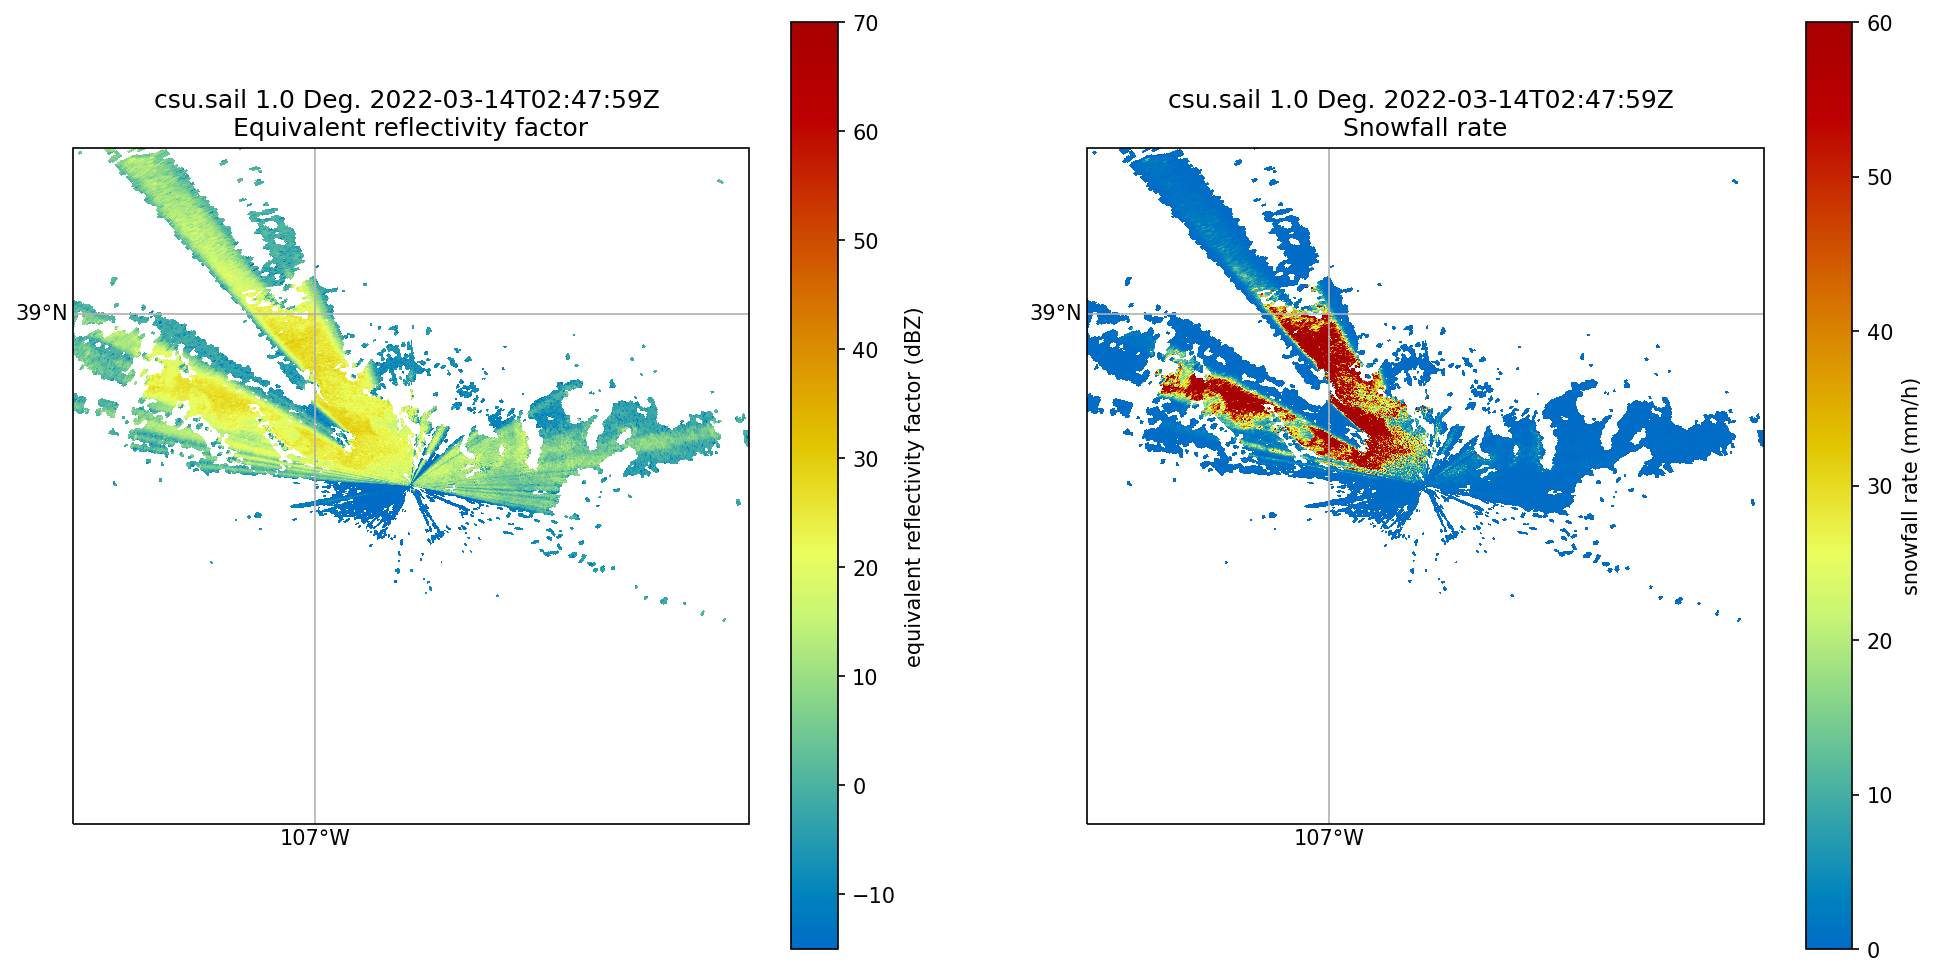

In [9]:
        fig = plt.figure(figsize=[16,18],dpi=150)  #Create figure

        ax1 = plt.subplot(221,projection = ccrs.PlateCarree())
        ax1.coastlines(linewidth=0.1,resolution='50m',zorder=2)
        ax1.add_feature(cartopy.feature.STATES,linewidth=0.1,zorder=1)
        display.plot_ppi_map('DBZ',vmin=-15, vmax=70,
                                         min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                                         resolution='10m',ax=ax1,
                                         cmap=pyart.graph.cm_colorblind.HomeyerRainbow,fig=fig,
                                         lat_0=center_lat,lon_0=center_lon,
                                         colorbar_flag=1,gatefilter=gatefilter)
        

        ax2 = plt.subplot(222,projection = ccrs.PlateCarree())
        ax2.coastlines(linewidth=0.1,resolution='50m',zorder=2)
        ax2.add_feature(cartopy.feature.STATES,linewidth=0.1,zorder=1)

        # Plot a PPI, lowest tilt. Use the Homeyer CVD friendly colormap. Range between zere and smax mm/hr
        # Skip the bells and whistles, we will roll our own (embelish)
        display.plot_ppi_map('snow_z',vmin=0, vmax=smax,min_lon=min_lon, max_lon=max_lon,
                             min_lat=min_lat, max_lat=max_lat, ax=ax2,colorbar_flag=1,
                        cmap=pyart.graph.cm_colorblind.HomeyerRainbow,gatefilter=gatefilter)

        # This will clear the figure if you're looping through multiple files of data. 
        #Otherwise you may continue to write over the same image
        # plt.clf()